In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [26]:
def calStability(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                continue
                
#             print("STA", list(_m["accuracy"]))
#             print("===============================")
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
            values[m].append(val)
    
    return values

In [95]:
def calPlasticity(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                continue
    
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            if len(_m) != len(_ideal):
                values[m].append(np.nan)
                continue
            
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            
            # Ignore when val is much more than 4; due to deternimator is too large
            if val > 4:
                print("task order", t)
                _m = list(_m["accuracy"])
                _ideal = list(_ideal)
                
                cnt = 0
                acc = 0.0
                for i in range(len(_m)):
                    if _m[i] / _ideal[i] > 4:
                        print(_m[i] / _ideal[i])
                        continue
                        
                    cnt +=1
                    acc += _m[i] / _ideal[i]
                val = acc
            
            values[m].append(val)
            
    
    return values

In [96]:
def calOverallAcc(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            
            _m = target[target["train_session"]==len(task_index)][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            

            if len(_m) != len(_ideal):
#                 print("SKIP", m, t)
                values[m].append(np.nan)
                continue
            
            val = np.nansum(_m["accuracy"].div(_ideal.values, axis=0))/len(_m)
            
            # Ignore when val is much more than 4; due to deternimator is too large
            if val > 4:
                
                print("task order", t)
                _m = list(_m["accuracy"])
                _ideal = list(_ideal)
                
                cnt = 0
                acc = 0.0
                for i in range(len(_m)):
                    if _m[i] / _ideal[i] > 4:
                        print(_m[i] / _ideal[i])
                        continue
                        
                    cnt +=1
                    acc += _m[i] / _ideal[i]
                val = acc
            
            values[m].append(val)
            
    return values

In [97]:
all_values = {}
for d in ["DSADS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_component_sensitivity/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
        print(c)
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

0
task order 0
112.99999999999999
1
task order 0
112.99999999999999
2
task order 0
93.0
3
task order 0
122.0
task order 0
37.99999999999999
4
5
task order 0
94.0
6
DSADS DONE


# Plots

In [90]:
from scipy import stats

def plot(values, title, width=0.85, offset_ratio=0, xticks=[], models=None, rotation=-45, filename="plot.pdf"):
    
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rcParams.update({'font.size': 25})
    plt.rcParams['axes.titlepad'] = 10
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    # values[cmd]["sg-cgan"][task_order]
    for model in models:
        
        tmp = []
        tmperr = []
#         for i, v in enumerate(values):
        for i in [0, 1, 2, 3, 4, 6]:
            v = values[i]
            
            
            avg = np.nanmean(v[model])
            err = stats.sem(v[model], nan_policy="omit")
            tmp.append(avg)
            tmperr.append(err)
            
        
        m.append(tmp)
        merr.append(tmperr)
    
    # m[model_index][cmd]
    print("Plot values")
    print(m[0])
    print(merr[0])
    
    ind = np.arange(len(xticks)) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])
        
        X = np.arange(-0.5, len(m[0])+0.5)
        Y = [m[i][0] for _ in range(len(X))]
        ax.plot(X, Y, linestyle=':')

    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation, rotation_mode="default", fontdict={"fontsize":20}, horizontalalignment='left')
#     ax.legend()

    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    

In [91]:
xticks = [
    "None",
    "Self-verify",
    "SMOTE",
    "EWC",
    "LwF",
#     "Instance Noise",
    "All"
]

Plot values
[0.6149754442567252, 0.5948266190270332, 0.5671367574499009, 0.6814597924950154, 1.0546662794849875, 1.1409505470790082]
[0.1200311575130339, 0.08977304193877231, 0.09711009194527519, 0.09668254176482403, 0.18698578787774991, 0.2203157459884759]


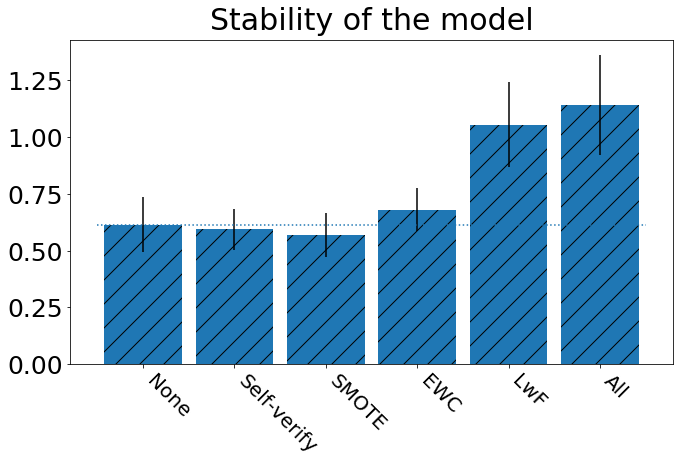

Plot values
[1.9473618460629745, 1.956582953311215, 1.9522533501510095, 1.938063872520886, 1.1647018471444321, 1.3285327744868296]
[0.4267319372701224, 0.42494229288648244, 0.42593012681764475, 0.4267446372939683, 0.12703396610276846, 0.12384842746490944]


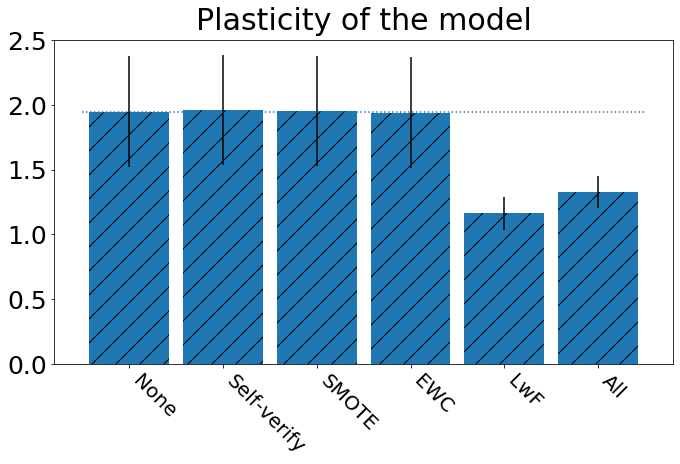

Plot values
[0.74382890845924, 0.536210038730047, 0.42214757536397585, 0.6145299278773247, 0.5492195136011464, 0.745436688793801]
[0.32081004382302236, 0.05760534787116699, 0.06459862899507583, 0.22226888661010846, 0.0716616548027131, 0.03353720232784853]


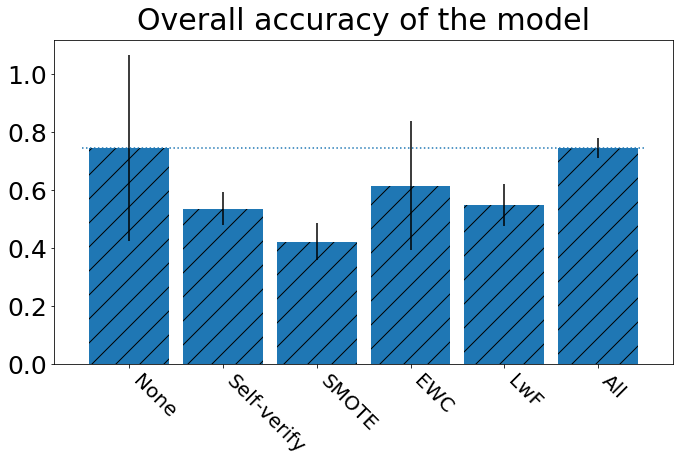

In [92]:

stability, plasticity, overallAcc = all_values["DSADS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models, filename="comp_DSADS_sta.pdf")
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models, filename="comp_DSADS_pla.pdf")
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models, filename="comp_DSADS_ova.pdf")